In [43]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from datetime import timedelta
from pmdarima.arima import auto_arima
from sklearn.metrics import root_mean_squared_error


In [44]:
df = pd.read_csv("../dataset.csv", index_col="ts", parse_dates = True)
df.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01 21:15:00,1,34.3262,33.3125,3262.0,84,27.9,0.1,100
2025-04-01 21:30:00,2,33.9057,33.4688,3232.5,84,27.8,0.1,100
2025-04-01 21:45:00,3,33.2979,33.5938,3218.0,85,27.8,0.1,100
2025-04-01 22:00:00,4,33.6201,33.3281,3211.0,85,27.6,0.0,100
2025-04-01 22:15:00,5,33.2979,33.3438,3203.0,85,27.6,0.0,100


In [45]:
df = df.resample('D').mean()
df.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01,6.0,30.485055,33.485800,3211.045455,83.909091,28.200000,0.027273,96.363636
2025-04-02,46.0,27.144790,33.753629,3158.710145,62.623188,31.623188,0.000000,87.246377
2025-04-03,128.5,25.908357,33.485352,3121.473958,76.322917,29.742708,0.025000,81.854167
2025-04-04,224.5,25.931506,33.122399,3223.473958,72.354167,30.153125,0.000000,36.416667
2025-04-05,320.0,141.128589,33.805593,3099.052632,71.084211,30.283158,0.000000,63.873684


# EDA

In [46]:
df["soil_moisture"].diff().dropna()

ts
2025-04-02    -52.335310
2025-04-03    -37.236187
2025-04-04    102.000000
2025-04-05   -124.421327
2025-04-06     32.826489
2025-04-07    -68.651725
2025-04-08     69.215312
2025-04-09     26.310538
2025-04-10    -27.613541
2025-04-11     14.303593
2025-04-12     16.791076
2025-04-13     12.218750
2025-04-14    -54.355299
Freq: D, Name: soil_moisture, dtype: float64

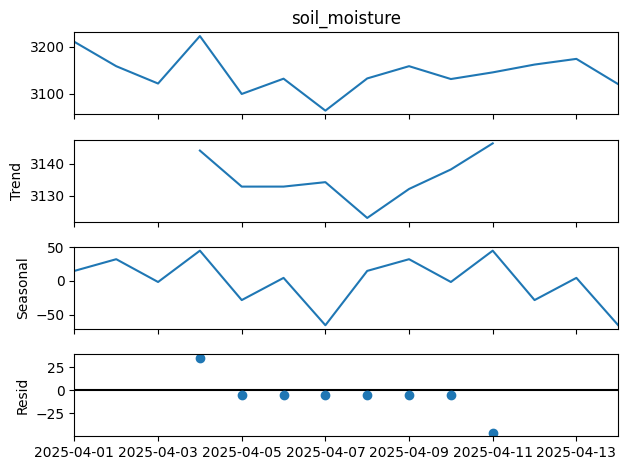

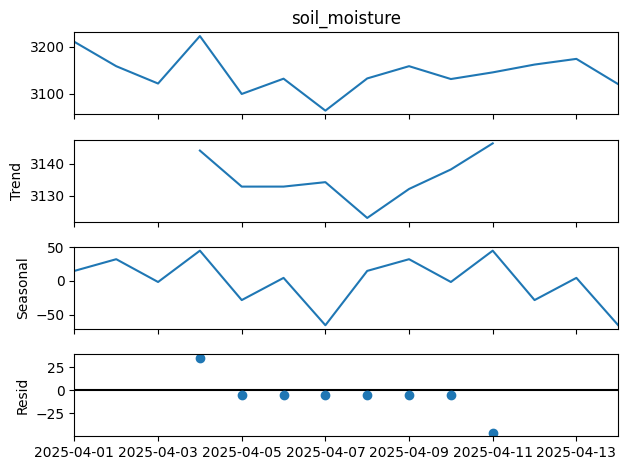

In [47]:
seasonal_decompose(df["soil_moisture"], model="additive").plot()


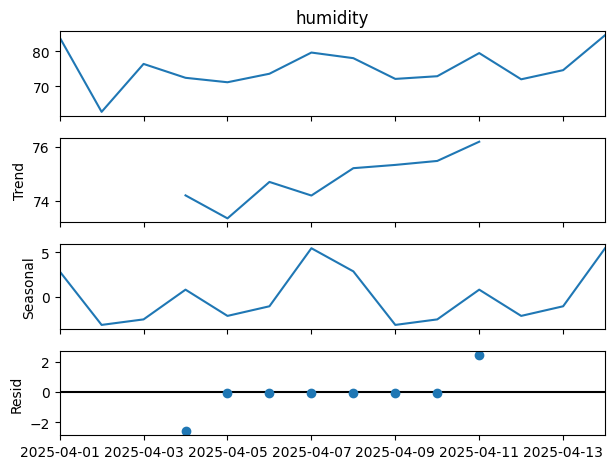

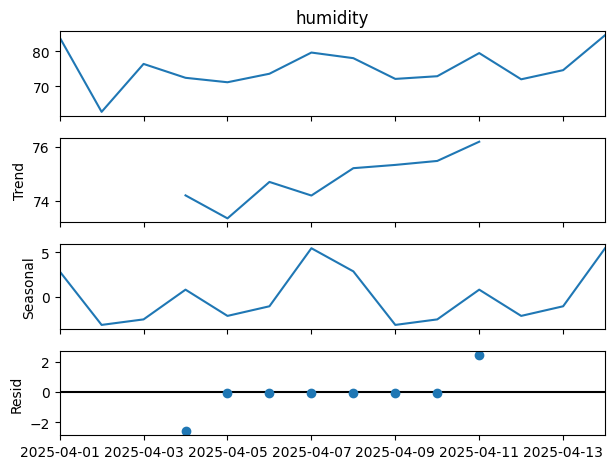

In [48]:
seasonal_decompose(df["humidity"], model="additive").plot()

## Find D parameter

In [49]:
result = adfuller(df["soil_moisture"].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -8.718835440467966
p-value: 3.429297974474895e-14
Critial Values:
   1%, -4.6651863281249994
Critial Values:
   5%, -3.3671868750000002
Critial Values:
   10%, -2.802960625


Since p-value is less than 0.05, the data is stationary and no differencing is needed.

Therefore, we use d=0.

## Find P parameter

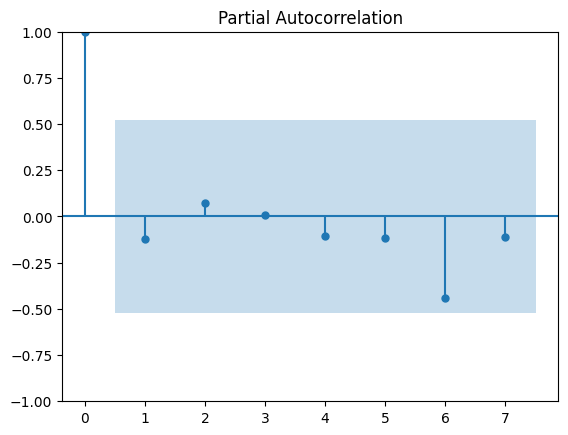

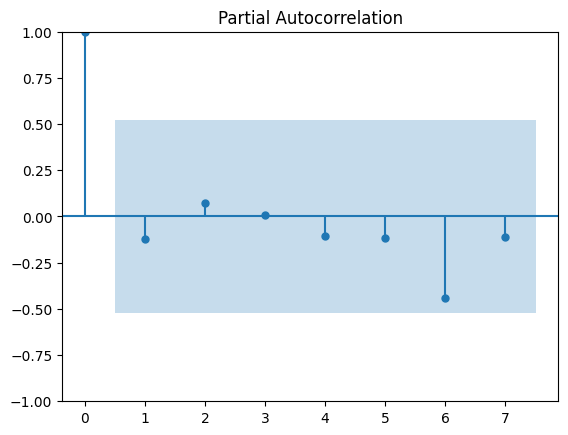

In [50]:
# I believe 2 or 3 is the variable for the term AR in order
plot_pacf(df["soil_moisture"])


## Find Q parameter

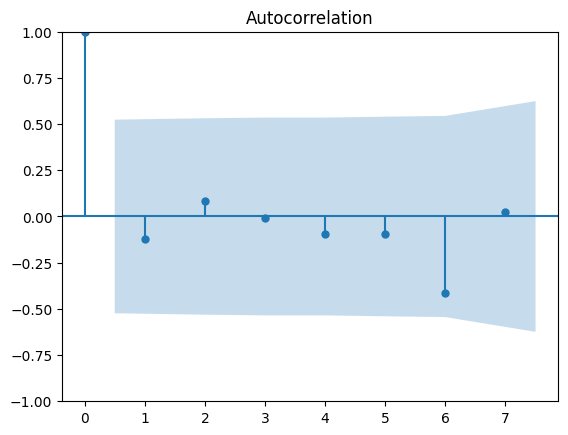

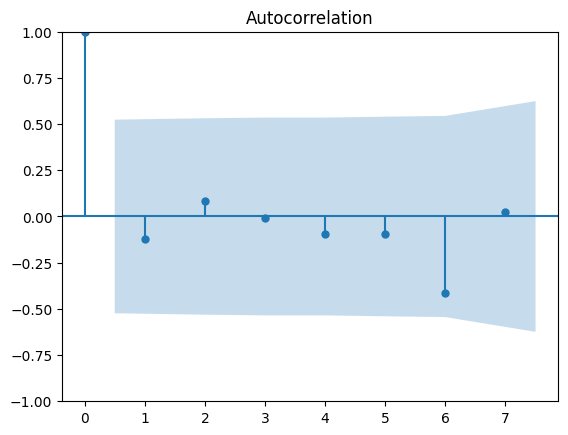

In [51]:
plot_acf(df["soil_moisture"])

## Split the data

In [52]:
train_end = datetime(2025,4,9)
test_end = datetime(2025,4,11)

train_data = df[:train_end]
test_data = df[train_end:test_end]
# test_data = df[train_end + timedelta(days=1):test_end]

In [53]:
train_data.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-01,6.0,30.485055,33.485800,3211.045455,83.909091,28.200000,0.027273,96.363636
2025-04-02,46.0,27.144790,33.753629,3158.710145,62.623188,31.623188,0.000000,87.246377
2025-04-03,128.5,25.908357,33.485352,3121.473958,76.322917,29.742708,0.025000,81.854167
2025-04-04,224.5,25.931506,33.122399,3223.473958,72.354167,30.153125,0.000000,36.416667
2025-04-05,320.0,141.128589,33.805593,3099.052632,71.084211,30.283158,0.000000,63.873684


In [54]:
test_data.head()

,id,light,temperature,soil_moisture,humidity,api_temp,precipitation,cloud_cover
ts,,,,,,,,
2025-04-09,689.0,23.082801,32.123174,3158.753247,72.038961,30.761039,0.005195,60.181818
2025-04-10,761.5,24.993522,31.644756,3131.139706,72.808824,30.464706,0.011765,97.176471
2025-04-11,844.0,24.186542,31.560729,3145.443299,79.422680,29.112371,0.047423,93.958763


In [55]:
train_data[["soil_moisture"]]

,soil_moisture
ts,
2025-04-01,3211.045455
2025-04-02,3158.710145
2025-04-03,3121.473958
2025-04-04,3223.473958
2025-04-05,3099.052632
2025-04-06,3131.879121
2025-04-07,3063.227396
2025-04-08,3132.442708
2025-04-09,3158.753247


In [56]:
arima_model = auto_arima(train_data[["soil_moisture"]], start_p=1, start_q=1,
                      test='padf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,          
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=95.027, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=93.576, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=93.093, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.139 seconds


c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.wa

wtf?

In [57]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                    9
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -45.547
Date:                Sun, 27 Apr 2025   AIC                             93.093
Time:                        22:16:48   BIC                             93.173
Sample:                    04-01-2025   HQIC                            92.557
                         - 04-09-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5160.3876   3852.902      1.339      0.180   -2391.162    1.27e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.93   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.05   Prob(JB):                         0.80
Heteroskedasticity (H):               0.70   Skew:                            -0.07
Prob(H) (two-sided):                  0.78   Kurtosis:                         1.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
test_data['soil_moisture'].count()



3

In [59]:
prediction = pd.DataFrame(arima_model.predict(n_periods = int(test_data['soil_moisture'].count()), index=test_data.index))
prediction.columns = ['predicted']
prediction

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,predicted
2025-04-10,3158.753247
2025-04-11,3158.753247
2025-04-12,3158.753247


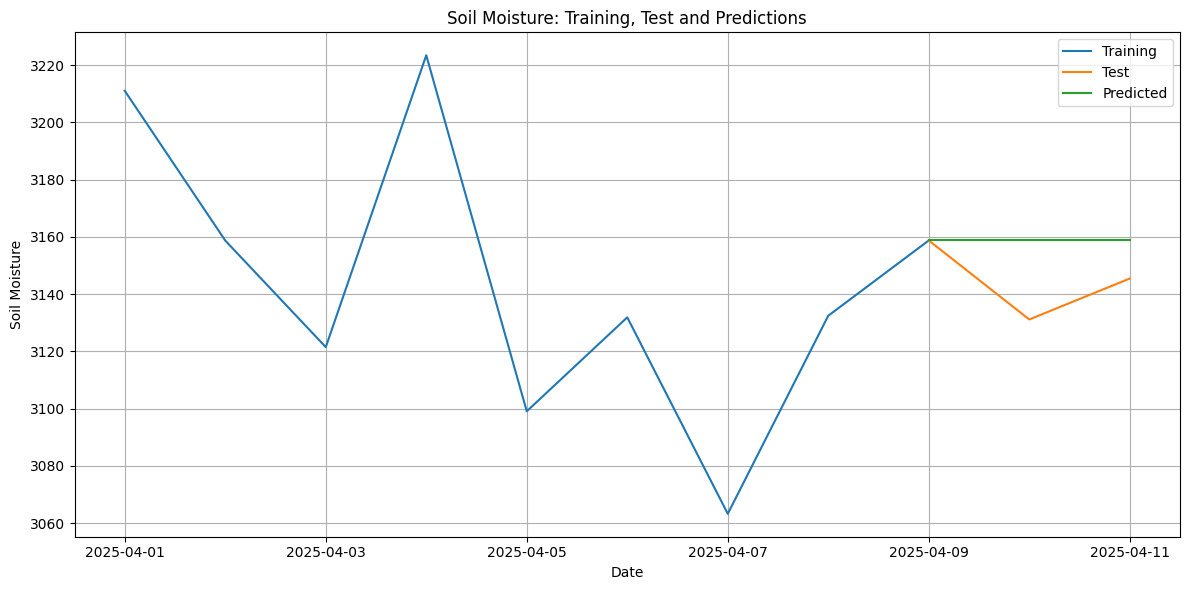

In [60]:
plt.figure(figsize=(12, 6))

# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["soil_moisture"], label="Training")
plt.plot(test_data.index, test_data["soil_moisture"], label="Test")
plt.plot(test_data.index, prediction, label="Predicted")  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("Soil Moisture")
plt.title("Soil Moisture: Training, Test and Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

In [61]:
# Get the RMSE
rmse = root_mean_squared_error(test_data['soil_moisture'], prediction)
print(rmse)

17.698044613704056
